In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
EnsureChannelFirstd,
EnsureTyped,
SpatialPadD,
CenterSpatialCropD,
RandCropByPosNegLabeld,
)
from monai.utils import set_determinism

In [2]:
import torch
print("CUDA availability:", torch.cuda.is_available())
print("device count: ", torch.cuda.device_count())
print_config()

# Define a new transform to convert brain tumor labels
# Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.
# Setup data directory
# You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.
# This allows you to save results and reuse downloads.
# If not specified a temporary directory will be used.

base_dir = './'
print(base_dir)
set_determinism(seed=0)

CUDA availability: True
device count:  1
MONAI version: 1.1.0
Numpy version: 1.26.4
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/asw9267/.local/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
Pillow version: 10.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.7.3
TorchVision version: 0.18.0+cu121
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.1.4
einops version: 0.8.0
transformers version: 4.40.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

./


In [3]:
class ConvertLabelsToMultiChannel(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        converted_data = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(converted_data[key] == 2, converted_data[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(converted_data[key] == 2, converted_data[key] == 3), converted_data[key] == 1
                )
            )
            # label 2 is ET
            result.append(converted_data[key] == 2)
            converted_data[key] = np.stack(result, axis=0).astype(np.float32)
        return converted_data

In [4]:
# Setup transforms for training and validation
training_roi_size = [128, 128, 64]
voxel_spacing = (1.5, 1.5, 2.0)

# train_transforms = Compose(
#     [
#         # load 4 Nifti images and stack them together
#         LoadImaged(keys=["image", "label"]),
#         AsChannelFirstd(keys="image"),
#         ConvertLabelsToMultiChannel(keys="label"),
#         Spacingd(
#             keys=["image", "label"],
#             pixdim=voxel_spacing,
#             mode=("bilinear", "nearest"),
#         ),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         RandSpatialCropd(
#             keys=["image", "label"], roi_size=training_roi_size, random_size=False),
#         RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
#         NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
#         RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
#         RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
#         ToTensord(keys=["image", "label"]),
#     ]
# )

train_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys="image"),
            EnsureTyped(keys=["image", "label"]),
            ConvertLabelsToMultiChannel(keys="label"),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            SpatialPadD(
                keys=["image", "label"],
                spatial_size=(255, 255, 128),
                method="symmetric",
                mode="constant",
            ),
            Spacingd(
                keys=["image", "label"],
                pixdim=voxel_spacing,
                mode=("bilinear", "nearest"),
            ),
            CenterSpatialCropD(
                keys=["image", "label"],
                roi_size=training_roi_size,
            ),
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                num_samples=2,
                spatial_size=training_roi_size,
                pos=1,
                neg=1,
                image_key="image",
                image_threshold=0,
            ),
            RandFlipd(
                keys=["image", "label"], prob=0.5, spatial_axis=0
            ),
            RandFlipd(
                keys=["image", "label"], prob=0.5, spatial_axis=1
            ),
            RandFlipd(
                keys=["image", "label"], prob=0.5, spatial_axis=2
            ),
            NormalizeIntensityd(
                keys="image", nonzero=True, channel_wise=True
            ),
            RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
            ToTensord(keys=["image", "label"]),
        ]
)
# validation_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         AsChannelFirstd(keys="image"),
#         ConvertLabelsToMultiChannel(keys="label"),
#         Spacingd(
#             keys=["image", "label"],
#             pixdim=voxel_spacing,
#             mode=("bilinear", "nearest"),
#         ),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         CenterSpatialCropd(keys=["image", "label"], roi_size=training_roi_size),
#         NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
#         ToTensord(keys=["image", "label"]),
#     ]
# )

validation_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertLabelsToMultiChannel(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=voxel_spacing,
            mode=("bilinear", "nearest"),
        ),
        CenterSpatialCropD(
            keys=["image", "label"],
            roi_size=training_roi_size,  # Ensure this matches the training ROI size
        ),
        NormalizeIntensityd(
            keys="image", nonzero=True, channel_wise=True
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

In [5]:
# Quickly load data with DecathlonDataset
# Here we use `DecathlonDataset` to automatically download and extract the dataset.
# It inherits MONAI `CacheDataset`, so we set `cache_num=100` to cache 100 items for training and use the defaut args to cache all the items for validation.

cache_items = 8

train_dataset = DecathlonDataset(
    root_dir=base_dir,
    task="Task01_BrainTumour",
    transform=train_transforms,
    section="training",
    download=True,
    num_workers=0,
    cache_num=cache_items, # it was 100 but we use larger volumes
)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
val_dataset = DecathlonDataset(
    root_dir=base_dir,
    task="Task01_BrainTumour",
    transform=validation_transforms,
    section="validation",
    download=False,
    num_workers=0,
    cache_num=cache_items,
)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)


2024-05-23 22:48:50,704 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-05-23 22:48:50,706 - INFO - File exists: Task01_BrainTumour.tar, skipped downloading.
2024-05-23 22:48:50,708 - INFO - Non-empty folder exists in Task01_BrainTumour, skipped extracting.


Loading dataset:   0%|          | 0/8 [00:00<?, ?it/s]/home/asw9267/.local/lib/python3.11/site-packages/monai/transforms/spatial/array.py:692: UserWarning: `data_array` is not of type `MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type `MetaTensor, assuming affine to be identity.")
Loading dataset: 100%|██████████| 8/8 [00:14<00:00,  1.81s/it]


image shape: torch.Size([4, 128, 128, 64])


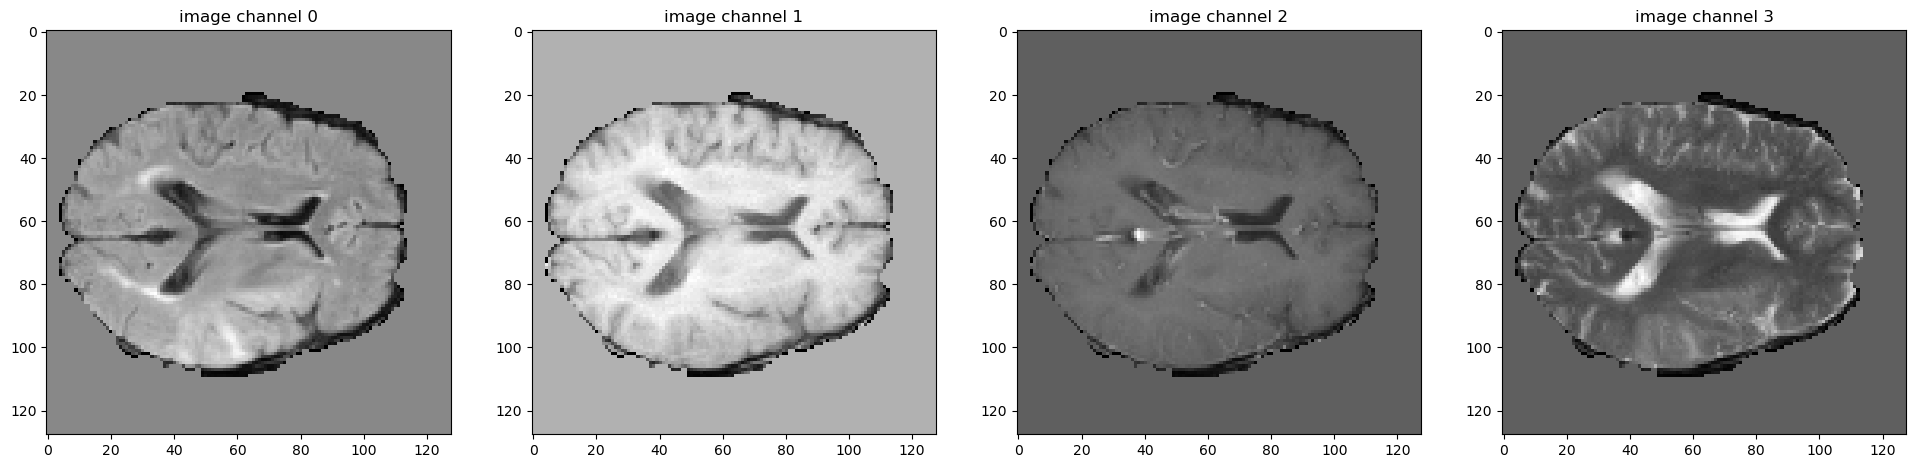

label shape: torch.Size([3, 128, 128, 64])


<Figure size 640x480 with 0 Axes>

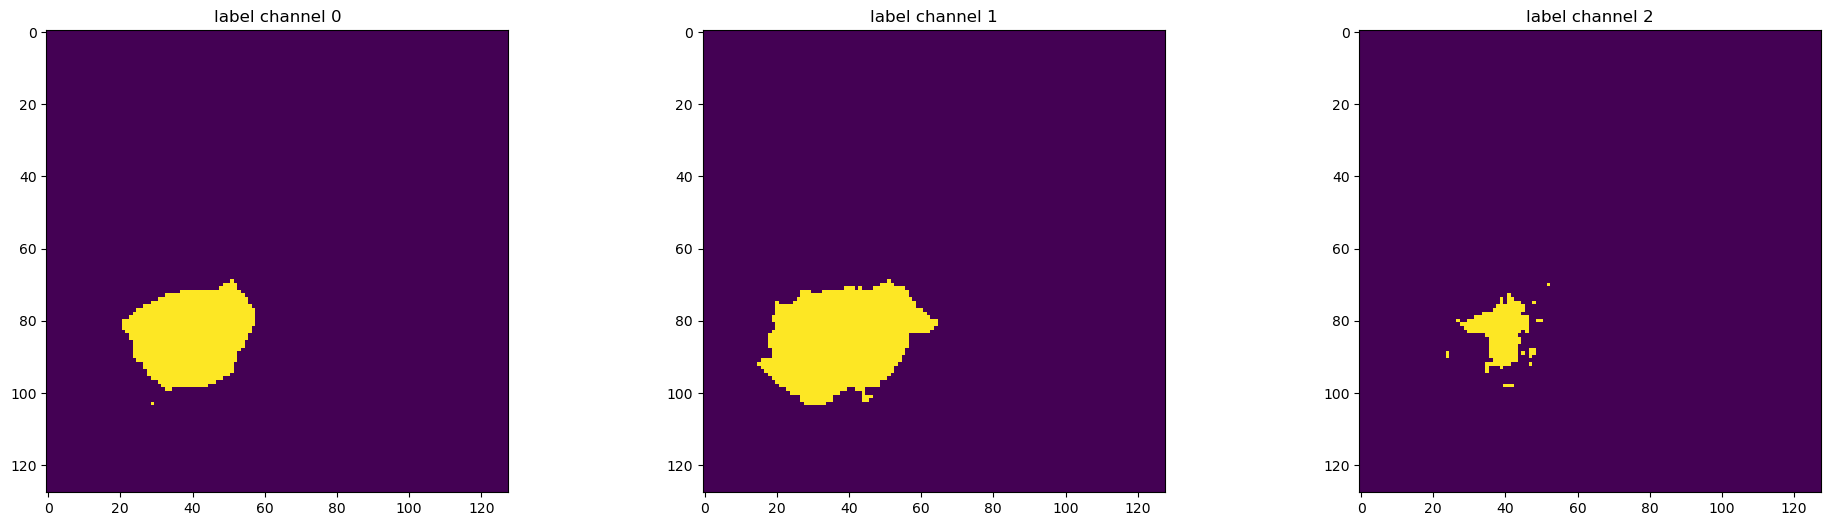

(128, 128, 64)


<Figure size 640x480 with 0 Axes>

In [6]:

# Check data shape and visualize
slice_index = 32
# pick one image from DecathlonDataset to visualize and check the 4 channels
print(f"image shape: {val_dataset[2]['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_dataset[2]["image"][i, :, :, slice_index].detach().cpu(),  cmap="gray") #
plt.show()
plt.savefig("fig1.png")
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_dataset[2]['label'].shape}")
plt.figure("label", (24, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_dataset[6]["label"][i, :, :, slice_index].detach().cpu())
plt.show()
plt.savefig("fig2.png")
training_shape = tuple(val_dataset[6]['image'].shape[1:])
print(training_shape)

In [7]:
# Proposed transformer based model

from einops import rearrange
import os
import random
from typing import List, Tuple
import numpy as np
import torch
from einops import repeat
from torch import Tensor, nn


class Conv3DLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, double=True, norm=nn.BatchNorm3d, skip=True):
        super().__init__()
        self.skip = skip
        self.downsample = in_channels != out_channels
        self.final_activation = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        padding = (kernel_size - 1) // 2
        if double:
            self.conv_block = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=1,
                          padding=padding),
                norm(out_channels),
                nn.LeakyReLU(negative_slope=0.01, inplace=True),
                nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, stride=1,
                          padding=padding),
                norm(out_channels))
        else:
            self.conv_block = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=1,
                          padding=padding),
                norm(out_channels))

        if self.skip and self.downsample:
            self.conv_down = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=1,
                          padding=0),
                norm(out_channels))

    def forward(self, x):
        y = self.conv_block(x)
        if self.skip:
            res = x
            if self.downsample:
                res = self.conv_down(res)
            y = y + res
        return self.final_activation(y)


In [8]:
# green block in Fig.1
class TransposeConv3DLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2,
                                        padding=0, output_padding=0, bias=False)

    def forward(self, x):
        y = self.block(x)
        return y


In [9]:
class BlueLayer(nn.Module):
    def __init__(self, in_channels, out_channels, layers=1, conv_block=False):
        """
        blue box in Fig.1
        Args:
            in_channels: in channels of transpose convolution
            out_channels: out channels of transpose convolution
            layers: number of blue blocks, transpose convs
            conv_block: whether to include a conv block after each transpose conv. deafaults to False
        """
        super().__init__()
        self.blocks = nn.ModuleList([TransposeConv3DLayer(in_channels, out_channels),
                                     ])
        if conv_block:
            self.blocks.append(Conv3DLayer(out_channels, out_channels, double=False))

        if int(layers) >= 2:
            for _ in range(int(layers) - 1):
                self.blocks.append(TransposeConv3DLayer(out_channels, out_channels))
                if conv_block:
                    self.blocks.append(Conv3DLayer(out_channels, out_channels, double=False))

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x

In [10]:
def expand_batch(tensor, desired_size):
    tile = desired_size // tensor.shape[0]
    return repeat(tensor, 'b ... -> (b tile) ...', tile=tile)


def set_random_seed(seed, gpu=False):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if gpu:
        torch.backends.cudnn.deterministic = True


# from https://huggingface.co/transformers/_modules/transformers/modeling_utils.html
def get_device_of_module(parameter: nn.Module):
    try:
        return next(parameter.parameters()).device
    except StopIteration:
        # For nn.DataParallel compatibility in PyTorch 1.5

        def find_tensor_attributes(module: nn.Module) -> List[Tuple[str, Tensor]]:
            tuples = [(k, v) for k, v in module.__dict__.items() if torch.is_tensor(v)]
            return tuples

        gen = parameter._named_members(get_members_fn=find_tensor_attributes)
        first_tuple = next(gen)
        return first_tuple[1].device


class AbsolutePositionalEncoding(nn.Module):
    def __init__(self, tokens, dim):
        super(AbsolutePositionalEncoding, self).__init__()
        self.abs_pos_enc = nn.Parameter(torch.randn(1, tokens, dim))

    def forward(self, x):
        batch = x.size()[0]
        return x + expand_batch(self.abs_pos_enc, desired_size=batch)


In [11]:
class Embedding3D(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size=16, dropout=0.1):
        super().__init__()
        self.n_patches = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_embeddings = nn.Conv3d(in_channels=input_dim, out_channels=embed_dim,
                                          kernel_size=patch_size, stride=patch_size, bias=False)
        self.position_embeddings = AbsolutePositionalEncoding(self.n_patches, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        x is a 5D tensor
        """
        x = rearrange(self.patch_embeddings(x), 'b d x y z -> b (x y z) d')
        embeddings = self.dropout(self.position_embeddings(x))
        return embeddings


In [12]:
def multi_head_self_attention(q, k, v, scale_factor=1, mask=None):
    # resulted shape will be: [batch, heads, tokens, tokens]
    scaled_dot_prod = torch.einsum('... i d , ... j d -> ... i j', q, k) * scale_factor

    if mask is not None:
        assert mask.shape == scaled_dot_prod.shape[2:]
        scaled_dot_prod = scaled_dot_prod.masked_fill(mask, -np.inf)

    attention = torch.softmax(scaled_dot_prod, dim=-1)
    # calc result per head
    return torch.einsum('... i j , ... j d -> ... i d', attention, v)

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=None):
        """
        Implementation of multi-head attention layer of the original transformer model.
        einsum and einops.rearrange is used whenever possible
        Args:
            dim: token's dimension, i.e. word embedding vector size
            heads: the number of distinct representations to learn
            dim_head: the dim of the head. In general dim_head<dim.
            However, it may not necessary be (dim/heads)
        """
        super().__init__()
        self.dim_head = (int(dim / heads)) if dim_head is None else dim_head
        _dim = self.dim_head * heads
        self.heads = heads
        self.to_qvk = nn.Linear(dim, _dim * 3, bias=False)
        self.W_0 = nn.Linear(_dim, dim, bias=False)
        self.scale_factor = self.dim_head ** -0.5

    def forward(self, x, mask=None):
        assert x.dim() == 3
        qkv = self.to_qvk(x)  # [batch, tokens, dim*3*heads ]

        # decomposition to q,v,k and cast to tuple
        # the resulted shape before casting to tuple will be: [3, batch, heads, tokens, dim_head]
        q, k, v = tuple(rearrange(qkv, 'b t (d k h ) -> k b h t d ', k=3, h=self.heads))

        out = multi_head_self_attention(q, k, v, mask=mask, scale_factor=self.scale_factor)

        # re-compose: merge heads with dim_head
        out = rearrange(out, "b h t d -> b t (h d)")
        # Apply final linear transformation layer
        return self.W_0(out)

In [14]:
class TransformerLayer(nn.Module):
    """
    Vanilla transformer block from the original paper "Attention is all you need"
    Detailed analysis: https://theaisummer.com/transformer/
    """

    def __init__(self, dim, heads=8, dim_head=None,
                 dim_linear_block=1024, dropout=0.1, activation=nn.GELU,
                 mhsa=None, prenorm=False):
        """
        Args:
            dim: token's vector length
            heads: number of heads
            dim_head: if none dim/heads is used
            dim_linear_block: the inner projection dim
            dropout: probability of droppping values
            mhsa: if provided you can change the vanilla self-attention block
            prenorm: if the layer norm will be applied before the mhsa or after
        """
        super().__init__()
        self.mhsa = mhsa if mhsa is not None else MultiHeadAttention(dim=dim, heads=heads, dim_head=dim_head)
        self.prenorm = prenorm
        self.drop = nn.Dropout(dropout)
        self.norm_1 = nn.LayerNorm(dim)
        self.norm_2 = nn.LayerNorm(dim)

        self.linear = nn.Sequential(
            nn.Linear(dim, dim_linear_block),
            activation(),  # nn.ReLU or nn.GELU
            nn.Dropout(dropout),
            nn.Linear(dim_linear_block, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        if self.prenorm:
            y = self.drop(self.mhsa(self.norm_1(x), mask)) + x
            out = self.linear(self.norm_2(y)) + y
        else:
            y = self.norm_1(self.drop(self.mhsa(x, mask)) + x)
            out = self.norm_2(self.linear(y) + y)
        return out


In [15]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, dropout, extract_layers, dim_linear_block):
        super().__init__()
        self.layer = nn.ModuleList()
        self.extract_layers = extract_layers

        # makes TransformerBlock device aware
        self.block_list = nn.ModuleList()
        for _ in range(num_layers):
            self.block_list.append(TransformerLayer(dim=embed_dim, heads=num_heads,
                                                    dim_linear_block=dim_linear_block, dropout=dropout, prenorm=True))

    def forward(self, x):
        extract_layers = []
        for depth, layer_block in enumerate(self.block_list):
            x = layer_block(x)
            if (depth + 1) in self.extract_layers:
                extract_layers.append(x)

        return extract_layers


In [16]:
# based on https://arxiv.org/abs/2103.10504
# implementation is influenced by practical details missing in the paper that can be found
# https://github.com/Project-MONAI/MONAI/blob/027947bf91ff0dfac94f472ed1855cd49e3feb8d/monai/networks/nets/unetr.py
class UNETR(nn.Module):
    def __init__(self, img_shape=(128, 128, 128), input_dim=4, output_dim=3,
                 embed_dim=768, patch_size=16, num_heads=12, dropout=0.0,
                 ext_layers=[3, 6, 9, 12], norm='instance',
                 base_filters=16,
                 dim_linear_block=3072):
        """
        Args:
            img_shape: volume shape, provided as a tuple
            input_dim: input modalities/channels
            output_dim: number of classes
            embed_dim: transformer embed dim.
            patch_size: the non-overlapping patches to be created
            num_heads: for the transformer encoder
            dropout: percentage for dropout
            ext_layers: transformer layers to use their output
            version: 'light' saves some parameters in the decoding part
            norm: batch or instance norm for the conv blocks
        """
        super().__init__()
        self.num_layers = 12
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.ext_layers = ext_layers
        self.patch_dim = [int(x / patch_size) for x in img_shape]

        self.norm = nn.BatchNorm3d if norm == 'batch' else nn.InstanceNorm3d

        self.embed = Embedding3D(input_dim=input_dim, embed_dim=embed_dim,
                                  cube_size=img_shape, patch_size=patch_size, dropout=dropout)

        self.transformer = TransformerEncoder(embed_dim, num_heads,
                                              self.num_layers, dropout, ext_layers,
                                              dim_linear_block=dim_linear_block)

        self.init_conv = Conv3DLayer(input_dim, base_filters, double=True, norm=self.norm)

        # blue blocks in Fig.1
        self.z3_blue_conv = BlueLayer(in_channels=embed_dim, out_channels=base_filters * 2, layers=3)

        self.z6_blue_conv = BlueLayer(in_channels=embed_dim, out_channels=base_filters * 4, layers=2)

        self.z9_blue_conv = BlueLayer(in_channels=embed_dim, out_channels=base_filters * 8, layers=1)

        # Green blocks in Fig.1
        self.z12_deconv = TransposeConv3DLayer(embed_dim, base_filters * 8)

        self.z9_deconv = TransposeConv3DLayer(base_filters * 8, base_filters * 4)
        self.z6_deconv = TransposeConv3DLayer(base_filters * 4, base_filters * 2)
        self.z3_deconv = TransposeConv3DLayer(base_filters * 2, base_filters)

        # Yellow blocks in Fig.1
        self.z9_conv = Conv3DLayer(base_filters * 8 * 2, base_filters * 8, double=True, norm=self.norm)
        self.z6_conv = Conv3DLayer(base_filters * 4 * 2, base_filters * 4, double=True, norm=self.norm)
        self.z3_conv = Conv3DLayer(base_filters * 2 * 2, base_filters * 2, double=True, norm=self.norm)
        # out convolutions
        self.out_conv = nn.Sequential(
            # last yellow conv block
            Conv3DLayer(base_filters * 2, base_filters, double=True, norm=self.norm),
            # grey block, final classification layer
            nn.Conv3d(base_filters, output_dim, kernel_size=1, stride=1))

    def forward(self, x):
        transf_input = self.embed(x)
        z3, z6, z9, z12 = map(lambda t: rearrange(t, 'b (x y z) d -> b d x y z',
                                                  x=self.patch_dim[0], y=self.patch_dim[1], z=self.patch_dim[2]),
                              self.transformer(transf_input))

        # Blue convs
        z0 = self.init_conv(x)
        z3 = self.z3_blue_conv(z3)
        z6 = self.z6_blue_conv(z6)
        z9 = self.z9_blue_conv(z9)

        # Green block for z12
        z12 = self.z12_deconv(z12)
        # Concat + yellow conv
        y = torch.cat([z12, z9], dim=1)
        y = self.z9_conv(y)

        # Green block for z6
        y = self.z9_deconv(y)
        # Concat + yellow conv
        y = torch.cat([y, z6], dim=1)
        y = self.z6_conv(y)

        # Green block for z3
        y = self.z6_deconv(y)
        # Concat + yellow conv
        y = torch.cat([y, z3], dim=1)
        y = self.z3_conv(y)

        y = self.z3_deconv(y)
        y = torch.cat([y, z0], dim=1)
        return self.out_conv(y)


In [17]:
device = torch.device("cuda")
num_attention_heads = 10 # 12 normally
embedding_dim = 512 # 768 normally

model = UNETR(img_shape=tuple(training_roi_size), input_dim=4, output_dim=3,
                 embed_dim=embedding_dim, patch_size=16, num_heads=num_attention_heads,
               ext_layers=[3, 6, 9, 12], norm='instance',
                 base_filters=16,
                 dim_linear_block=2048).to(device)

total_params = sum(p.numel() for p in model.parameters())/1000000
print('Parameters in millions:',total_params)


Parameters in millions: 49.667123


In [18]:
import torch.nn as nn
from monai.losses import DiceLoss, DiceCELoss
from torch.optim.lr_scheduler import OneCycleLR

loss_function = DiceCELoss(to_onehot_y=False, sigmoid=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

max_epochs = 30
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

scheduler = OneCycleLR(optimizer, max_lr=1e-3, epochs=max_epochs, steps_per_epoch=len(train_loader))

torch.cuda.empty_cache()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, reduction="mean")
            post_trans = Compose(
                [Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
            )
            metric_sum = metric_sum_tc = metric_sum_wt = metric_sum_et = 0.0
            metric_count = (
                metric_count_tc
            ) = metric_count_wt = metric_count_et = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = model(val_inputs)
                val_outputs = post_trans(val_outputs)

                # compute overall mean dice
                value, not_nans = dice_metric(y_pred=val_outputs, y=val_labels)
                not_nans = not_nans.mean().item()
                metric_count += not_nans
                metric_sum += value.mean().item() * not_nans
                # compute mean dice for TC
                value_tc, not_nans = dice_metric(
                    y_pred=val_outputs[:, 0:1], y=val_labels[:, 0:1]
                )
                not_nans = not_nans.item()
                metric_count_tc += not_nans
                metric_sum_tc += value_tc.item() * not_nans
                # compute mean dice for WT
                value_wt, not_nans = dice_metric(
                    y_pred=val_outputs[:, 1:2], y=val_labels[:, 1:2]
                )
                not_nans = not_nans.item()
                metric_count_wt += not_nans
                metric_sum_wt += value_wt.item() * not_nans
                # compute mean dice for ET
                value_et, not_nans = dice_metric(
                    y_pred=val_outputs[:, 2:3], y=val_labels[:, 2:3]
                )
                not_nans = not_nans.item()
                metric_count_et += not_nans
                metric_sum_et += value_et.item() * not_nans

            metric = metric_sum / metric_count
            metric_values.append(metric)
            metric_tc = metric_sum_tc / metric_count_tc
            metric_values_tc.append(metric_tc)
            metric_wt = metric_sum_wt / metric_count_wt
            metric_values_wt.append(metric_wt)
            metric_et = metric_sum_et / metric_count_et
            metric_values_et.append(metric_et)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(
                    model.state_dict(),
                    os.path.join(base_dir, "best_metric_model1.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

save_path = "./last1.pth"
torch.save(model.state_dict(), save_path)

print(
    f"train completed, best_metric: {best_metric:.4f}"
    f" at epoch: {best_metric_epoch}"
)


----------
epoch 1/30


/home/asw9267/.local/lib/python3.11/site-packages/torch/_tensor.py:1443: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/asw9267/.local/lib/python3.11/site-packages/monai/data/__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t = cls([], dtype=storage.dtype, device=storage.device)
/home/asw9267/.local/lib/python3.11/site-packages/torch/_tensor.py:1443: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage 

epoch 1 average loss: 0.9988
----------
epoch 2/30
epoch 2 average loss: 0.9805
----------
epoch 3/30
epoch 3 average loss: 0.9671
----------
epoch 4/30
epoch 4 average loss: 0.9183
----------
epoch 5/30
epoch 5 average loss: 0.7547


/home/asw9267/.local/lib/python3.11/site-packages/monai/metrics/utils.py:219: UserWarning: y_pred should be a binarized tensor.
  warnings.warn(f"{name} should be a binarized tensor.")


saved new best metric model
current epoch: 5 current mean dice: 0.4359 tc: 0.5294 wt: 0.5338 et: 0.2397
best mean dice: 0.4359 at epoch: 5
----------
epoch 6/30
epoch 6 average loss: 0.5575
----------
epoch 7/30
epoch 7 average loss: 0.4619
----------
epoch 8/30
epoch 8 average loss: 0.4117
----------
epoch 9/30
epoch 9 average loss: 0.3977
----------
epoch 10/30
epoch 10 average loss: 0.3788
saved new best metric model
current epoch: 10 current mean dice: 0.6564 tc: 0.7118 wt: 0.7861 et: 0.4650
best mean dice: 0.6564 at epoch: 10
----------
epoch 11/30
epoch 11 average loss: 0.3672
----------
epoch 12/30
epoch 12 average loss: 0.3534
----------
epoch 13/30
epoch 13 average loss: 0.3532
----------
epoch 14/30
epoch 14 average loss: 0.3442
----------
epoch 15/30
epoch 15 average loss: 0.3500
saved new best metric model
current epoch: 15 current mean dice: 0.6895 tc: 0.7400 wt: 0.8371 et: 0.4891
best mean dice: 0.6895 at epoch: 15
----------
epoch 16/30
epoch 16 average loss: 0.3459
----

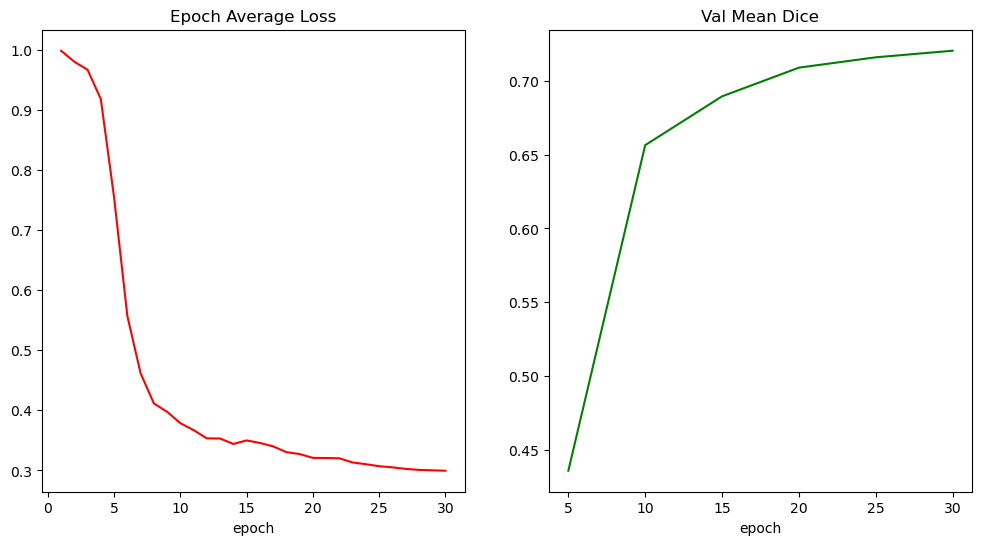

<Figure size 640x480 with 0 Axes>

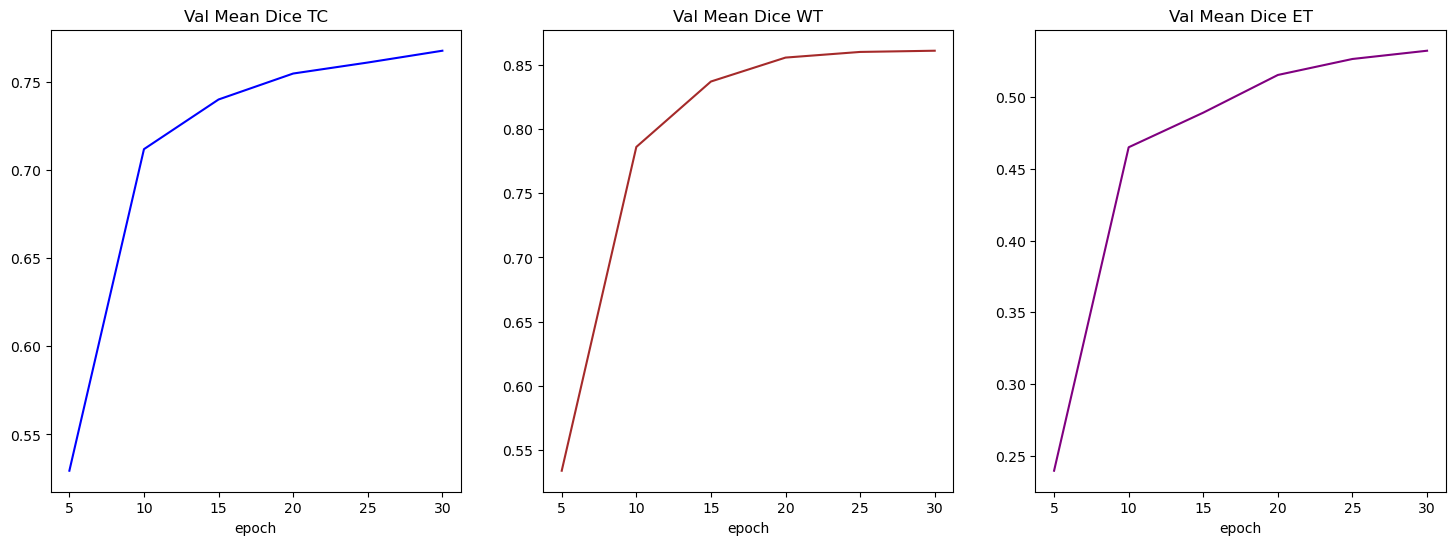

<Figure size 640x480 with 0 Axes>

In [19]:
# Plot the loss and metric

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()
plt.savefig("fig31.png")

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()
plt.savefig("fig41.png")

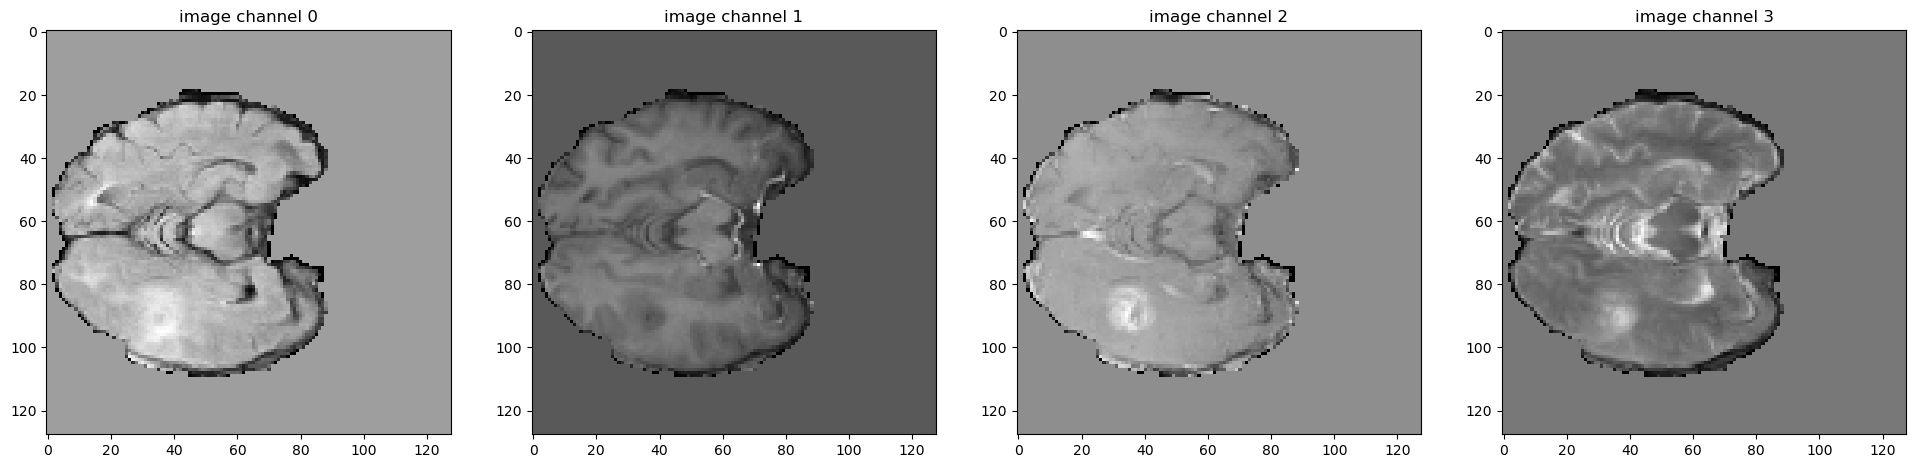

<Figure size 640x480 with 0 Axes>

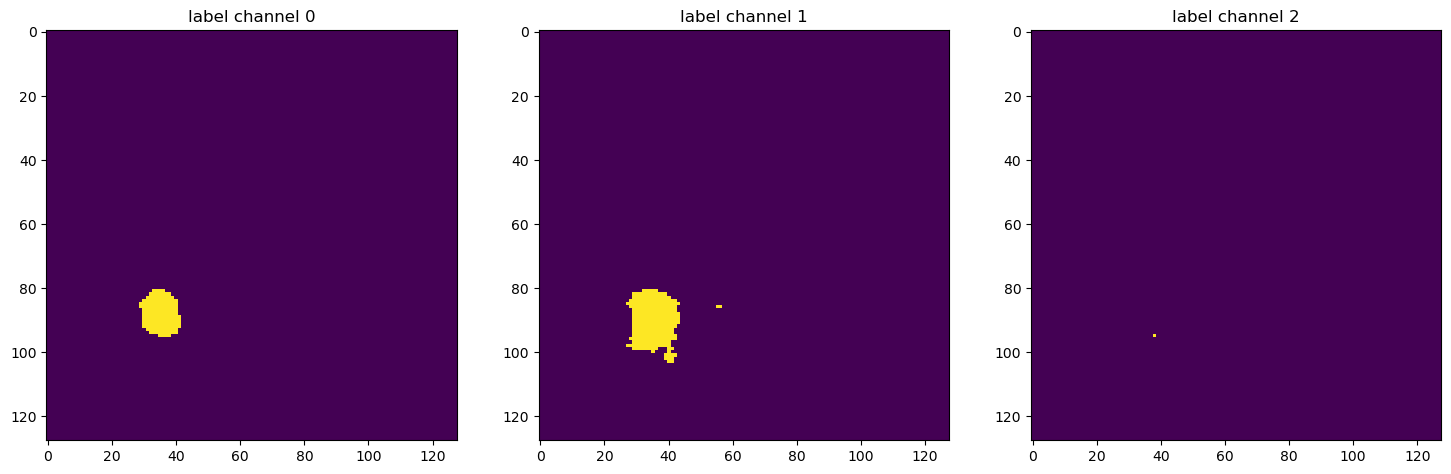

<Figure size 640x480 with 0 Axes>

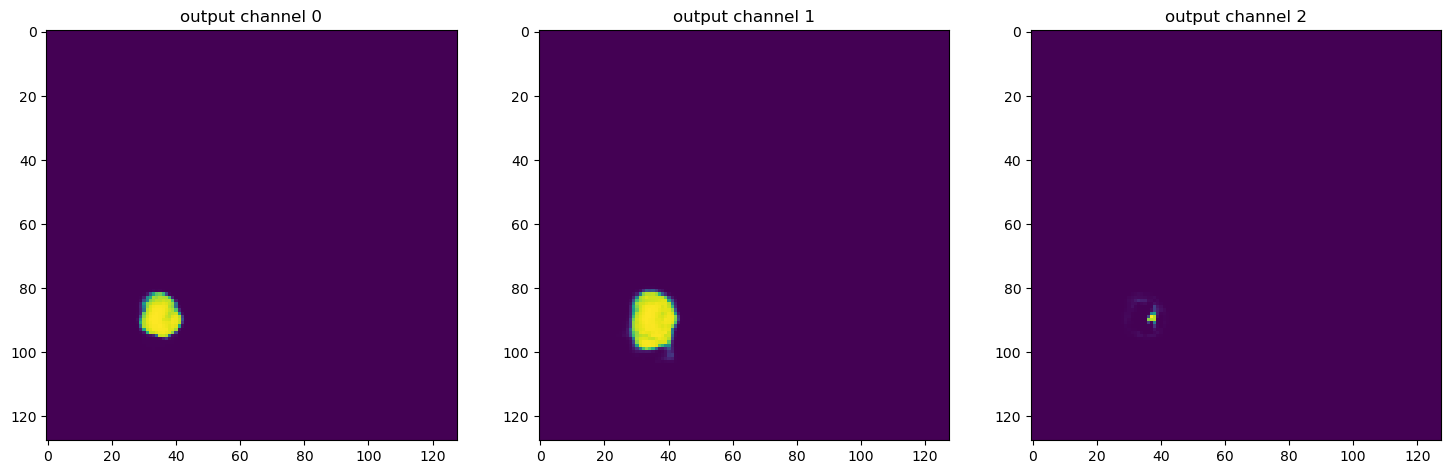

<Figure size 640x480 with 0 Axes>

In [20]:
# Check best model output with the input image and label

model.load_state_dict(
    torch.load(os.path.join(base_dir, "best_metric_model1.pth"))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_dataset[6]["image"].unsqueeze(0).to(device)
    val_output = model(val_input)
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_dataset[6]["image"][i, :, :, 20].detach().cpu(), cmap="gray")
    plt.show()
    plt.savefig("fig51.png")
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_dataset[6]["label"][i, :, :, 20].detach().cpu())
    plt.show()
    plt.savefig("fig61.png")
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        out_tensor = torch.sigmoid(val_output[0, i, :, :, 20]).detach().cpu()
        plt.imshow(out_tensor)
    plt.show()
    plt.savefig("fig71.png")
